In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.datasets import load_iris
from xgboost import XGBClassifier

In [2]:
import pandas as pd
Final_Dataset_Provider_Train = pd.read_csv('/content/Final_Dataset_Provider_Train.csv')
Final_Dataset_Provider_Test = pd.read_csv('/content/Final_Dataset_Provider_Test.csv')

In [3]:
Final_Dataset_Provider_Train.shape

(5410, 240)

In [4]:
Final_Dataset_Provider_Train['PotentialFraud'].replace(to_replace=['Yes','No'], value=[1,0], inplace=True)


In [5]:
Final_Dataset_Provider_Train.head(2)

,Provider,PotentialFraud,InscClaimAmtReimbursed,DeductibleAmtPaid,ClmProcedureCode_6,Hospitalization_Duration,Claim_Period,ClaimStart_Year,ClaimStart_Month,ClaimEnd_Year,...,PerClmAdmitDiagnosisCode_mean_patient_age,PerClmAdmitDiagnosisCode_mean_Hospitalization_Duration,PerClmAdmitDiagnosisCode_mean_Claim_Period,PerClmAdmitDiagnosisCode_mean_patient_risk_score,Gender_0,Gender_1,Race_1,Race_2,Race_3,Race_5
0,PRV51001,0,104640,5340.0,0.0,30.0,61,50225,125,50225,...,1872.124752,34.488500,79.928594,128.360407,16.0,9.0,21.0,4.0,0.0,0.0
1,PRV51003,1,605670,66286.0,0.0,382.0,617,265187,804,265188,...,9752.142258,248.575108,465.823969,662.905082,78.0,54.0,107.0,24.0,0.0,1.0


In [6]:
# Seperate dependent and independent variables
x_train = Final_Dataset_Provider_Train.drop(axis=1,columns=['Provider','PotentialFraud'])
y_train = Final_Dataset_Provider_Train['PotentialFraud']
x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

In [7]:
# ref : https://scikit-learn.org/stable/modules/preprocessing.html

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_standerizaed = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
# refer : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_trai, x_te, y_trai, y_te = train_test_split(x_train_standerizaed, y_train, test_size=0.3,random_state=42,stratify=y_train)

In [9]:
x_trai.shape ,x_te.shape , y_trai.shape , y_te.shape

((3787, 238), (1623, 238), (3787,), (1623,))

In [10]:
no_count = y_trai.value_counts()[0]
yes_count = y_trai.value_counts()[1]

fraud_percentage = (yes_count*100/(no_count+yes_count))
non_fraud_percentage = (no_count*100/(no_count+yes_count))

print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 9.35% and Non-Fraud Percentage = 90.65%


In [11]:
from collections import Counter


In [58]:
# write the code for 80:20 ratio spilitting 
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy=0.80 / (0.80 + 0.20), random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_trai, y_trai)
counter = Counter(y_train_res)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 44.44% and Non-Fraud Percentage = 55.56%


# **ENSEMBLE MODEL WITH TAKEN MODEL VALUE 10 with diff samples**

In [78]:


# Define the rare and abundant class
rare_class = 1
abundant_class = 0

# Split the data into training and testing sets

# Get indices of rare and abundant class
rare_indices = np.where(y_train_res == rare_class)[0]
abundant_indices = np.where(y_train_res == abundant_class)[0]

# Define the number of models to train
n_models = 10

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)
rf = RandomForestClassifier(n_estimators=400, min_samples_split=10, max_features='auto', max_depth=5, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define an empty list to store the models
models = []

# Train n models with different resampled datasets
for i in range(n_models):
    # Sample from the abundant class
    np.random.seed(i)
    np.random.shuffle(abundant_indices)
    selected_indices = np.concatenate((rare_indices, abundant_indices[:len(rare_indices)*n_models]))
    x_train_resampled = x_train_res[selected_indices]
    y_train_resampled = y_train_res[selected_indices]

    # Define the voting classifier
    voting_clf = VotingClassifier(
        estimators=[('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf), ('xgb', xgb)],
        voting='soft')

    # Fit the voting classifier on the resampled training data
    voting_clf.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_clf)

# Predict on the testing data using all models and average the predictions
y_preds = np.zeros((n_models, len(x_te)))
for i, model in enumerate(models):
    y_pred = model.predict_proba(x_te)
    y_preds[i] = y_pred[:, 1]
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred_final, average='macro')
roc_auc = roc_auc_score(y_te, y_pred_final, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7863133328042824
ROC AUC score of ensemble model: 0.8589372607248917


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

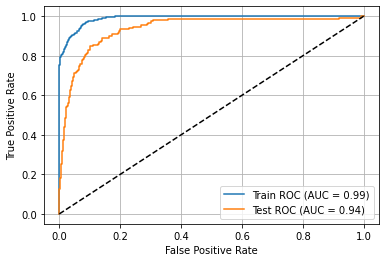

Test Confusion Matrix:
[[1356  115]
 [  33  119]]


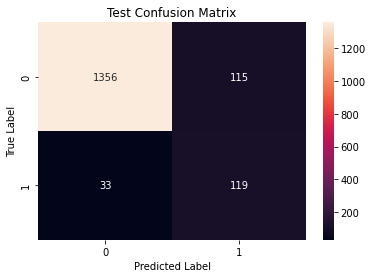

Train Confusion Matrix:
[[3218  215]
 [ 203 2543]]


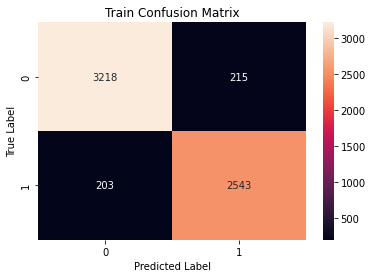

Test Precision: 0.51
Test Recall: 0.78
Test Confusion Matrix:
[[1356  115]
 [  33  119]]

Train Precision: 0.92
Train Recall: 0.93
Train Confusion Matrix:
[[3218  215]
 [ 203 2543]]


In [79]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

In [ ]:
# Select 10 random rows from the test set
random_rows = x_te.sample(n=10, random_state=42)

# Get the corresponding actual class labels
y_true = y_te.loc[random_rows.index]

# Predict the class labels using the voting classifier
y_pred = voting_clf.predict(random_rows)

# Print the actual and predicted class labels
for i in range(10):
    print("Row {}: Actual={}, Predicted={}".format(i+1, y_true.iloc[i], y_pred[i]))

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGISTIC REGRESSION ,RANDOM FOREST, XG-BOOST AND DECISION TREE AS BASE LEARNERS**

In [16]:




# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7875347935890931
ROC AUC score of ensemble model: 0.8383998533042327


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

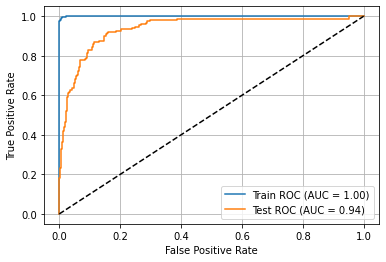

Test Confusion Matrix:
[[1373   98]
 [  39  113]]


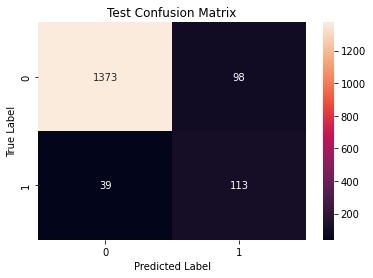

Train Confusion Matrix:
[[3378   55]
 [   7 2739]]


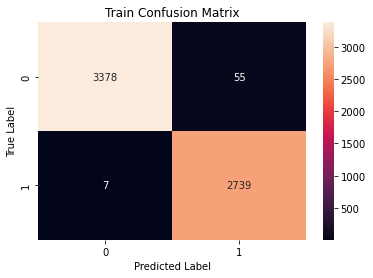

Test Precision: 0.54
Test Recall: 0.74
Test Confusion Matrix:
[[1373   98]
 [  39  113]]

Train Precision: 0.98
Train Recall: 1.00
Train Confusion Matrix:
[[3378   55]
 [   7 2739]]


In [17]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGESTIC REGRESSION , RANDOM FOREST , XG-BOOST, DECISION TREE, SVM WITH RBF KERNAL**

In [19]:

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

svm_rbf = SVC(C=10, kernel='rbf',probability=True)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt), ('svm_rbf', svm_rbf)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7895218584370184
ROC AUC score of ensemble model: 0.8469086550502701


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

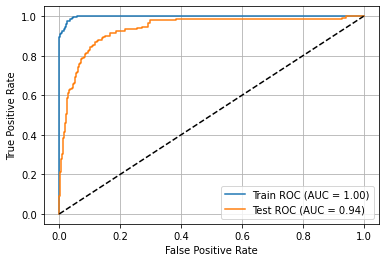

Test Confusion Matrix:
[[1369  102]
 [  36  116]]


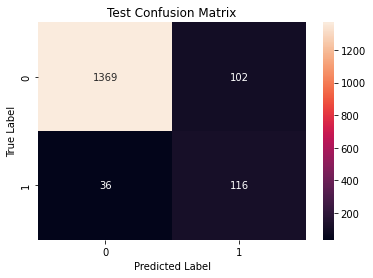

Train Confusion Matrix:
[[3321  112]
 [  63 2683]]


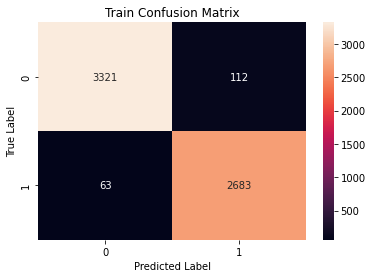

Test Precision: 0.53
Test Recall: 0.76
Test Confusion Matrix:
[[1369  102]
 [  36  116]]

Train Precision: 0.96
Train Recall: 0.98
Train Confusion Matrix:
[[3321  112]
 [  63 2683]]


In [20]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **NOW IMPLEMENTATION OF ENSEMBLE MODEL WITH RANDOM FOREST AND XGBOOST AS BASE LEARNERS**

In [21]:
# Define the base learners
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[ ('rf', rf), ('xgb', xgb)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7783532229599126
ROC AUC score of ensemble model: 0.7965356542273427


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

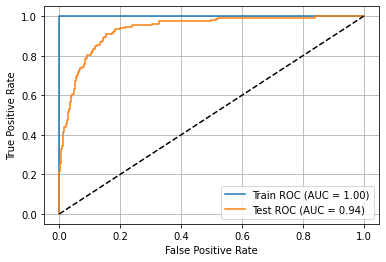

Test Confusion Matrix:
[[1395   76]
 [  54   98]]


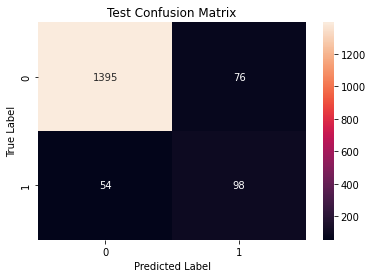

Train Confusion Matrix:
[[3433    0]
 [   0 2746]]


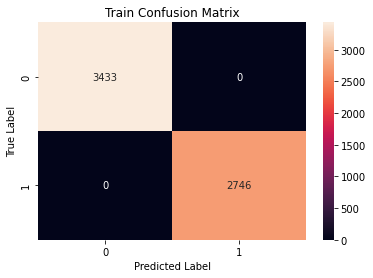

Test Precision: 0.56
Test Recall: 0.64
Test Confusion Matrix:
[[1395   76]
 [  54   98]]

Train Precision: 1.00
Train Recall: 1.00
Train Confusion Matrix:
[[3433    0]
 [   0 2746]]


In [22]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENATION OF ENSEMBLE MODEL WITH 3 RANDOM FOREST MODEL WITH DIFFERENT PARAMETERS AS BASE LEARNERS**

In [23]:
# Define the base learners
rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2 = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf3 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7669494813280784
ROC AUC score of ensemble model: 0.8390908440373538


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

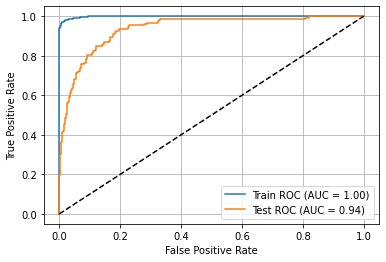

Test Confusion Matrix:
[[1346  125]
 [  36  116]]


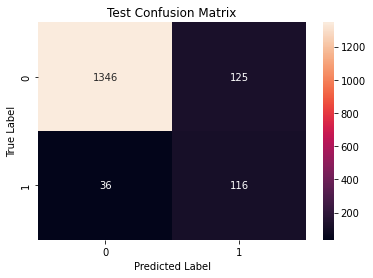

Train Confusion Matrix:
[[3277  156]
 [  30 2716]]


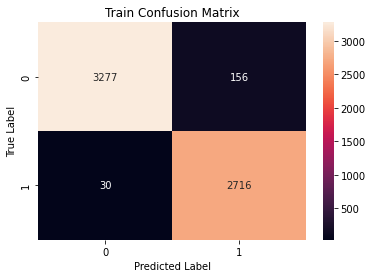

Test Precision: 0.48
Test Recall: 0.76
Test Confusion Matrix:
[[1346  125]
 [  36  116]]

Train Precision: 0.95
Train Recall: 0.99
Train Confusion Matrix:
[[3277  156]
 [  30 2716]]


In [24]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

In [73]:
from prettytable import PrettyTable

print("THIS IS different ensemble  MODEL PERFORMANCE IN 80:20 COMBINATIONS")

table = PrettyTable()
table.field_names = ["MODEL COMBINATION", "OVERSAMPLING RATIO", "AUC SCORE", "F1 SCORE", "TRAIN AUC", "TEST AUC", "TRAIN PRECISION", "TRAIN RECALL", "TEST PRECISION", "TEST RECALL"]
table.add_row(["LR+SVM+DT+RANDOM FOREST+XGBOOST", "80:20", 0.85, 0.76, 0.99, 0.94, 0.92, 0.93, 0.51, 0.78])
table.add_row([ "LR+DT+RANDOM FOREST+XGBOOST", "80:20", 0.83, 0.78, 1.00, 0.94, 0.98, 1.00, 0.54, 0.74])
table.add_row([ "LR+svm_rbf+DT+RANDOM FOREST+XGBOOST", "80:20", 0.84, 0.78, 1.00, 0.96, 0.98, 1.00, 0.53, 0.76])
table.add_row([ "RANDOM FOREST+XGBOOST", "80:20", 0.79, 0.77, 1.00, 1.00, 1.00, 1.00, 0.56, 0.64])
table.add_row([ "RANDOM FOREST+RANDOM FOREST+RANDOM FOREST", "80:20", 0.83, 0.76, 1.00, 0.94, 0.95, 0.99, 0.48, 0.76])
print(table)


THIS IS different ensemble  MODEL PERFORMANCE IN 80:20 COMBINATIONS
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|             MODEL COMBINATION             | OVERSAMPLING RATIO | AUC SCORE | F1 SCORE | TRAIN AUC | TEST AUC | TRAIN PRECISION | TRAIN RECALL | TEST PRECISION | TEST RECALL |
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|      LR+SVM+DT+RANDOM FOREST+XGBOOST      |       80:20        |    0.85   |   0.76   |    0.99   |   0.94   |       0.92      |     0.93     |      0.51      |     0.78    |
|        LR+DT+RANDOM FOREST+XGBOOST        |       80:20        |    0.83   |   0.78   |    1.0    |   0.94   |       0.98      |     1.0      |      0.54      |     0.74    |
|    LR+svm_rbf+DT+RANDOM FOREST+XGBOOST    |  

#**NOW WE WILL USE THE 75:25 SPLIT RATIO FOR OVERSAMPLING**

In [25]:
# write the code for 80:20 ratio spilitting 
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy= 0.75/ (0.75 + 0.25), random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_trai, y_trai)
counter = Counter(y_train_res)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 42.85% and Non-Fraud Percentage = 57.15%


# **ENSEMBLE MODEL WITH TAKEN MODEL VALUE 10 with diff samples**

In [26]:
# Define the rare and abundant class
rare_class = 1
abundant_class = 0

# Split the data into training and testing sets

# Get indices of rare and abundant class
rare_indices = np.where(y_train_res == rare_class)[0]
abundant_indices = np.where(y_train_res == abundant_class)[0]

# Define the number of models to train
n_models = 10

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define an empty list to store the models
models = []

# Train n models with different resampled datasets
for i in range(n_models):
    # Sample from the abundant class
    np.random.seed(i)
    np.random.shuffle(abundant_indices)
    selected_indices = np.concatenate((rare_indices, abundant_indices[:len(rare_indices)*n_models]))
    x_train_resampled = x_train_res[selected_indices]
    y_train_resampled = y_train_res[selected_indices]

    # Define the voting classifier
    voting_clf = VotingClassifier(
        estimators=[('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf), ('xgb', xgb)],
        voting='soft')

    # Fit the voting classifier on the resampled training data
    voting_clf.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_clf)

# Predict on the testing data using all models and average the predictions
y_preds = np.zeros((n_models, len(x_te)))
for i, model in enumerate(models):
    y_pred = model.predict_proba(x_te)
    y_preds[i] = y_pred[:, 1]
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred_final, average='macro')
roc_auc = roc_auc_score(y_te, y_pred_final, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7883846916663606
ROC AUC score of ensemble model: 0.8543977423163619


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

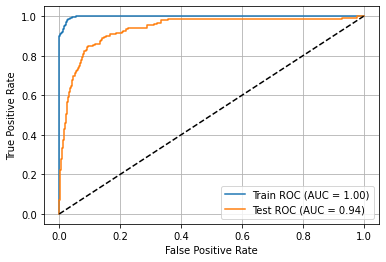

Test Confusion Matrix:
[[1364  107]
 [  34  118]]


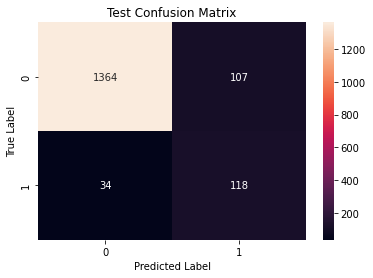

Train Confusion Matrix:
[[3336   97]
 [  44 2530]]


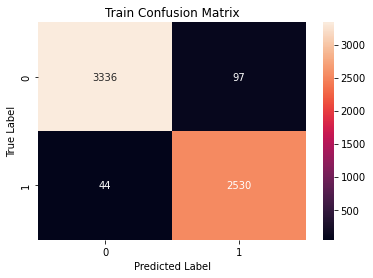

Test Precision: 0.52
Test Recall: 0.78
Test Confusion Matrix:
[[1364  107]
 [  34  118]]

Train Precision: 0.96
Train Recall: 0.98
Train Confusion Matrix:
[[3336   97]
 [  44 2530]]


In [27]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGISTIC REGRESSION ,RANDOM FOREST, XG-BOOST AND DECISION TREE AS BASE LEARNERS**

In [28]:
# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7834210427395407
ROC AUC score of ensemble model: 0.8396498980285519


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

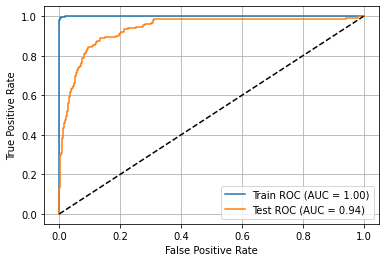

Test Confusion Matrix:
[[1367  104]
 [  38  114]]


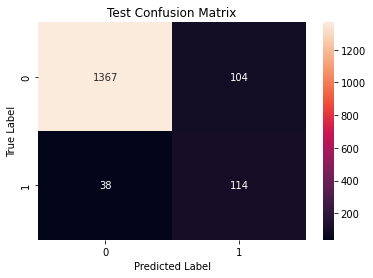

Train Confusion Matrix:
[[3389   44]
 [   7 2567]]


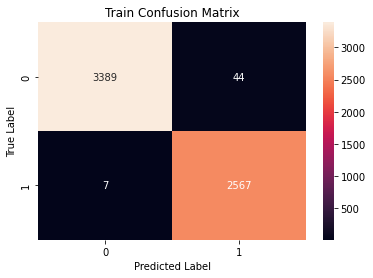

Test Precision: 0.52
Test Recall: 0.75
Test Confusion Matrix:
[[1367  104]
 [  38  114]]

Train Precision: 0.98
Train Recall: 1.00
Train Confusion Matrix:
[[3389   44]
 [   7 2567]]


In [29]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGESTIC REGRESSION , RANDOM FOREST , XG-BOOST, DECISION TREE, SVM WITH RBF KERNAL**

In [30]:

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

svm_rbf = SVC(C=10, kernel='rbf',probability=True)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt), ('svm_rbf', svm_rbf)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7804320476940307
ROC AUC score of ensemble model: 0.8438495116104332


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

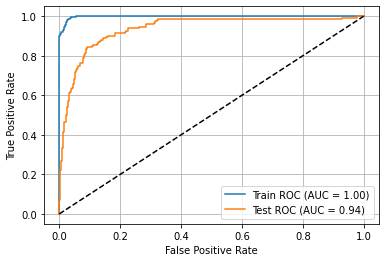

Test Confusion Matrix:
[[1360  111]
 [  36  116]]


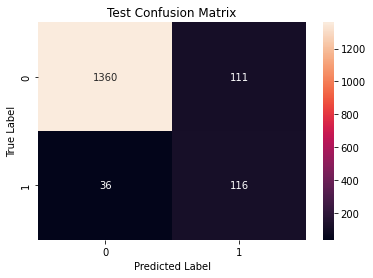

Train Confusion Matrix:
[[3335   98]
 [  43 2531]]


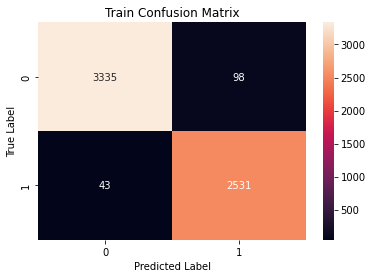

Test Precision: 0.51
Test Recall: 0.76
Test Confusion Matrix:
[[1360  111]
 [  36  116]]

Train Precision: 0.96
Train Recall: 0.98
Train Confusion Matrix:
[[3335   98]
 [  43 2531]]


In [31]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **NOW IMPLEMENTATION OF ENSEMBLE MODEL WITH RANDOM FOREST AND XGBOOST AS BASE LEARNERS**

In [32]:
# Define the base learners
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[ ('rf', rf), ('xgb', xgb)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7761622561393537
ROC AUC score of ensemble model: 0.7958558445740456



# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

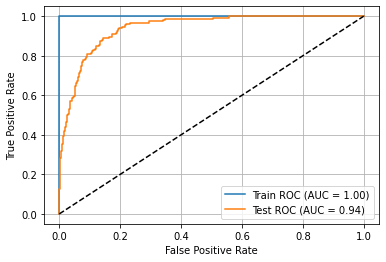

Test Confusion Matrix:
[[1393   78]
 [  54   98]]


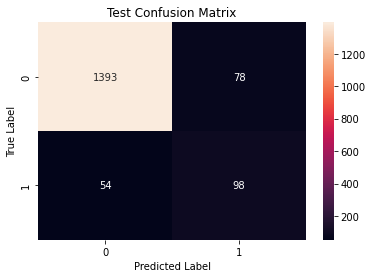

Train Confusion Matrix:
[[3433    0]
 [   1 2573]]


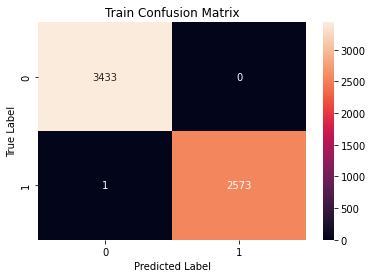

Test Precision: 0.56
Test Recall: 0.64
Test Confusion Matrix:
[[1393   78]
 [  54   98]]

Train Precision: 1.00
Train Recall: 1.00
Train Confusion Matrix:
[[3433    0]
 [   1 2573]]


In [33]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENATION OF ENSEMBLE MODEL WITH 3 RANDOM FOREST MODEL WITH DIFFERENT PARAMETERS AS BASE LEARNERS**

In [34]:
# Define the base learners
rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2 = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf3 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.781431803490627
ROC AUC score of ensemble model: 0.8546280725607357


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

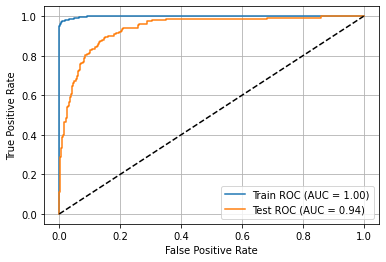

Test Confusion Matrix:
[[1353  118]
 [  32  120]]


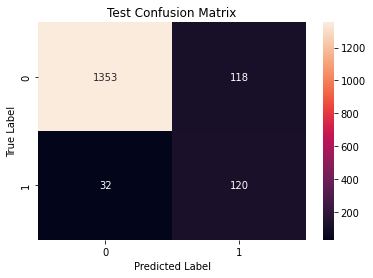

Train Confusion Matrix:
[[3284  149]
 [  34 2540]]


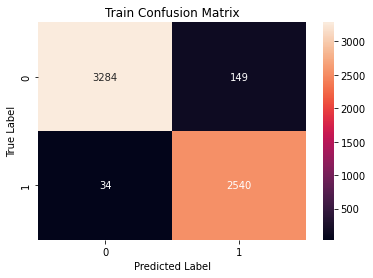

Test Precision: 0.50
Test Recall: 0.79
Test Confusion Matrix:
[[1353  118]
 [  32  120]]

Train Precision: 0.94
Train Recall: 0.99
Train Confusion Matrix:
[[3284  149]
 [  34 2540]]


In [35]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

In [75]:
from prettytable import PrettyTable

print("THIS IS different ensemble  MODEL PERFORMANCE IN 75:25 COMBINATIONS")

table = PrettyTable()
table.field_names = ["MODEL COMBINATION", "OVERSAMPLING RATIO", "AUC SCORE", "F1 SCORE", "TRAIN AUC", "TEST AUC", "TRAIN PRECISION", "TRAIN RECALL", "TEST PRECISION", "TEST RECALL"]
table.add_row(["LR+SVM+DT+RANDOM FOREST+XGBOOST", "75:25", 0.85, 0.78, 1.00, 0.94, 0.96, 0.98, 0.52, 0.78])
table.add_row([ "LR+DT+RANDOM FOREST+XGBOOST", "75:25", 0.83, 0.78, 1.00, 0.94, 0.98, 1.00, 0.52, 0.75])
table.add_row([ "LR+svm_rbf+DT+RANDOM FOREST+XGBOOST", "75:25", 0.84, 0.78, 1.00, 0.94, 0.96, 0.98, 0.51, 0.76])
table.add_row([ "RANDOM FOREST+XGBOOST", "75:25", 0.79, 0.77, 1.00, 0.94, 1.00, 1.00, 0.56, 0.64])
table.add_row([ "RANDOM FOREST+RANDOM FOREST+RANDOM FOREST", "75:25", 0.85, 0.78, 1.00, 0.94, 0.94, 0.99, 0.50, 0.79])
print(table)

THIS IS different ensemble  MODEL PERFORMANCE IN 75:25 COMBINATIONS
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|             MODEL COMBINATION             | OVERSAMPLING RATIO | AUC SCORE | F1 SCORE | TRAIN AUC | TEST AUC | TRAIN PRECISION | TRAIN RECALL | TEST PRECISION | TEST RECALL |
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|      LR+SVM+DT+RANDOM FOREST+XGBOOST      |       75:25        |    0.85   |   0.78   |    1.0    |   0.94   |       0.96      |     0.98     |      0.52      |     0.78    |
|        LR+DT+RANDOM FOREST+XGBOOST        |       75:25        |    0.83   |   0.78   |    1.0    |   0.94   |       0.98      |     1.0      |      0.52      |     0.75    |
|    LR+svm_rbf+DT+RANDOM FOREST+XGBOOST    |  

#**NOW WILL TRY THE MODEL ON 60:40 SPLIT COMBINATION WITH SMOTE SAMPLING**

In [36]:
# write the code for 80:20 ratio spilitting 
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy= 0.60/ (0.60 + 0.40), random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_trai, y_trai)
counter = Counter(y_train_res)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 37.49% and Non-Fraud Percentage = 62.51%


# **ENSEMBLE MODEL WITH TAKEN MODEL VALUE 10 with diff samples**

In [37]:
# Define the rare and abundant class
rare_class = 1
abundant_class = 0

# Split the data into training and testing sets

# Get indices of rare and abundant class
rare_indices = np.where(y_train_res == rare_class)[0]
abundant_indices = np.where(y_train_res == abundant_class)[0]

# Define the number of models to train
n_models = 10

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define an empty list to store the models
models = []

# Train n models with different resampled datasets
for i in range(n_models):
    # Sample from the abundant class
    np.random.seed(i)
    np.random.shuffle(abundant_indices)
    selected_indices = np.concatenate((rare_indices, abundant_indices[:len(rare_indices)*n_models]))
    x_train_resampled = x_train_res[selected_indices]
    y_train_resampled = y_train_res[selected_indices]

    # Define the voting classifier
    voting_clf = VotingClassifier(
        estimators=[('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf), ('xgb', xgb)],
        voting='soft')

    # Fit the voting classifier on the resampled training data
    voting_clf.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_clf)

# Predict on the testing data using all models and average the predictions
y_preds = np.zeros((n_models, len(x_te)))
for i, model in enumerate(models):
    y_pred = model.predict_proba(x_te)
    y_preds[i] = y_pred[:, 1]
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred_final, average='macro')
roc_auc = roc_auc_score(y_te, y_pred_final, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7916855043256374
ROC AUC score of ensemble model: 0.8423691366417403


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

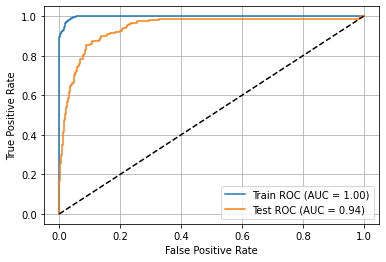

Test Confusion Matrix:
[[1379   92]
 [  38  114]]


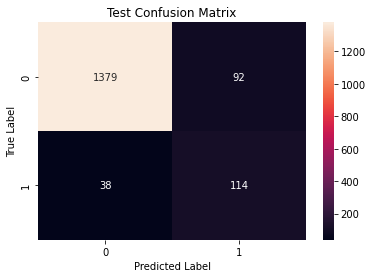

Train Confusion Matrix:
[[3340   93]
 [  45 2014]]


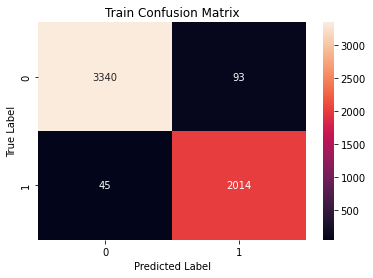

Test Precision: 0.55
Test Recall: 0.75
Test Confusion Matrix:
[[1379   92]
 [  38  114]]

Train Precision: 0.96
Train Recall: 0.98
Train Confusion Matrix:
[[3340   93]
 [  45 2014]]


In [38]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGISTIC REGRESSION ,RANDOM FOREST, XG-BOOST AND DECISION TREE AS BASE LEARNERS**

In [39]:
# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7759943237043662
ROC AUC score of ensemble model: 0.819002916025618


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

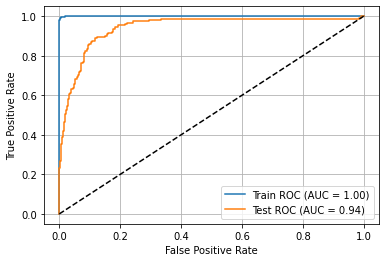

Test Confusion Matrix:
[[1374   97]
 [  45  107]]


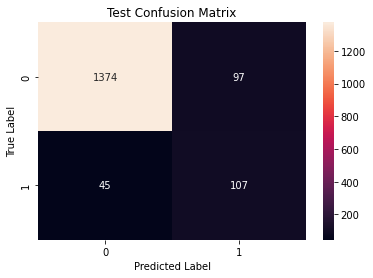

Train Confusion Matrix:
[[3403   30]
 [   5 2054]]


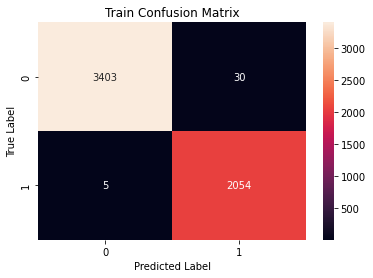

Test Precision: 0.52
Test Recall: 0.70
Test Confusion Matrix:
[[1374   97]
 [  45  107]]

Train Precision: 0.99
Train Recall: 1.00
Train Confusion Matrix:
[[3403   30]
 [   5 2054]]


In [40]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGESTIC REGRESSION , RANDOM FOREST , XG-BOOST, DECISION TREE, SVM WITH RBF KERNAL**

In [41]:
# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

svm_rbf = SVC(C=10, kernel='rbf',probability=True)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt), ('svm_rbf', svm_rbf)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7834142380273199
ROC AUC score of ensemble model: 0.8370402339976386


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

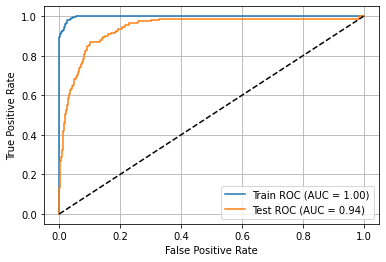

Test Confusion Matrix:
[[1369  102]
 [  39  113]]


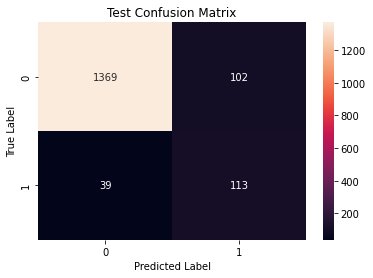

Train Confusion Matrix:
[[3340   93]
 [  43 2016]]


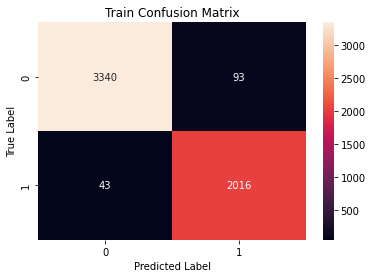

Test Precision: 0.53
Test Recall: 0.74
Test Confusion Matrix:
[[1369  102]
 [  39  113]]

Train Precision: 0.96
Train Recall: 0.98
Train Confusion Matrix:
[[3340   93]
 [  43 2016]]


In [42]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **NOW IMPLEMENTATION OF ENSEMBLE MODEL WITH RANDOM FOREST AND XGBOOST AS BASE LEARNERS**

In [43]:
# Define the base learners
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[ ('rf', rf), ('xgb', xgb)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7640864345292769
ROC AUC score of ensemble model: 0.7868975634190847


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

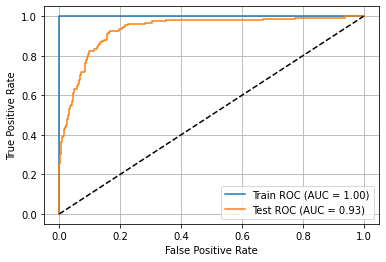

Test Confusion Matrix:
[[1386   85]
 [  56   96]]


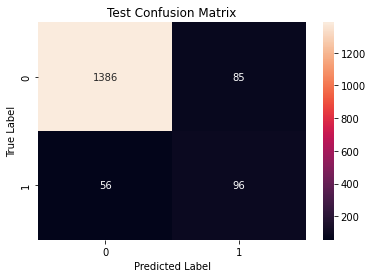

Train Confusion Matrix:
[[3433    0]
 [   0 2059]]


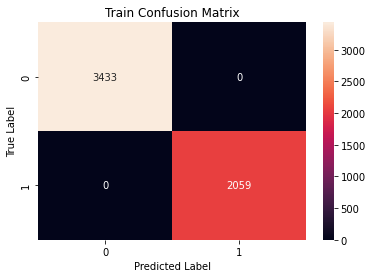

Test Precision: 0.53
Test Recall: 0.63
Test Confusion Matrix:
[[1386   85]
 [  56   96]]

Train Precision: 1.00
Train Recall: 1.00
Train Confusion Matrix:
[[3433    0]
 [   0 2059]]


In [44]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENATION OF ENSEMBLE MODEL WITH 3 RANDOM FOREST MODEL WITH DIFFERENT PARAMETERS AS BASE LEARNERS**

In [45]:
# Define the base learners
rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2 = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf3 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7844291187739463
ROC AUC score of ensemble model: 0.8452091309170274


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

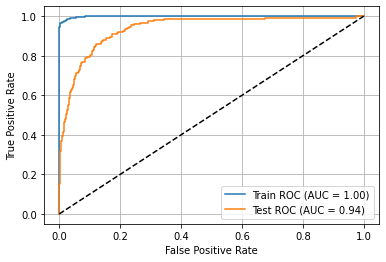

Test Confusion Matrix:
[[1364  107]
 [  36  116]]


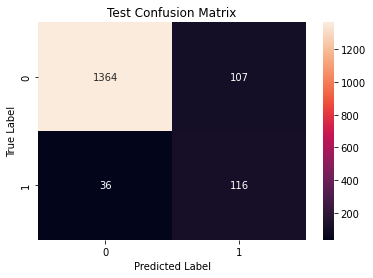

Train Confusion Matrix:
[[3319  114]
 [  25 2034]]


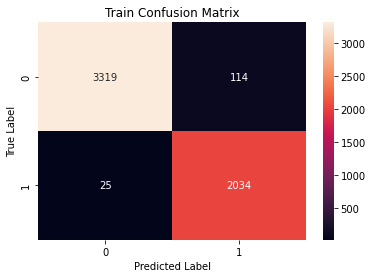

Test Precision: 0.52
Test Recall: 0.76
Test Confusion Matrix:
[[1364  107]
 [  36  116]]

Train Precision: 0.95
Train Recall: 0.99
Train Confusion Matrix:
[[3319  114]
 [  25 2034]]


In [46]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

In [76]:
from prettytable import PrettyTable

print("THIS IS different ensemble  MODEL PERFORMANCE IN 60:40 COMBINATIONS")

table = PrettyTable()
table.field_names = ["MODEL COMBINATION", "OVERSAMPLING RATIO", "AUC SCORE", "F1 SCORE", "TRAIN AUC", "TEST AUC", "TRAIN PRECISION", "TRAIN RECALL", "TEST PRECISION", "TEST RECALL"]
table.add_row(["LR+SVM+DT+RANDOM FOREST+XGBOOST", "60:40", 0.84, 0.79, 1.00, 0.94, 0.99, 1.00, 0.52, 0.70])
table.add_row([ "LR+DT+RANDOM FOREST+XGBOOST", "60:40", 0.81, 0.77, 1.00, 0.94, 0.98, 1.00, 0.52, 0.75])
table.add_row([ "LR+svm_rbf+DT+RANDOM FOREST+XGBOOST", "60:40", 0.83, 0.78, 1.00, 0.94, 0.96, 0.98, 0.53, 0.74])
table.add_row([ "RANDOM FOREST+XGBOOST", "60:40", 0.76, 0.78, 1.00, 0.93, 1.00, 1.00, 0.53, 0.63])
table.add_row([ "RANDOM FOREST+RANDOM FOREST+RANDOM FOREST", "60:40", 0.84, 0.78, 1.00, 0.94, 0.95, 0.99, 0.52, 0.76])
print(table)

THIS IS different ensemble  MODEL PERFORMANCE IN 60:40 COMBINATIONS
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|             MODEL COMBINATION             | OVERSAMPLING RATIO | AUC SCORE | F1 SCORE | TRAIN AUC | TEST AUC | TRAIN PRECISION | TRAIN RECALL | TEST PRECISION | TEST RECALL |
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|      LR+SVM+DT+RANDOM FOREST+XGBOOST      |       60:40        |    0.84   |   0.79   |    1.0    |   0.94   |       0.99      |     1.0      |      0.52      |     0.7     |
|        LR+DT+RANDOM FOREST+XGBOOST        |       60:40        |    0.81   |   0.77   |    1.0    |   0.94   |       0.98      |     1.0      |      0.52      |     0.75    |
|    LR+svm_rbf+DT+RANDOM FOREST+XGBOOST    |  

# **NOW WILL TRY THE 50:50 RATIO SMOTE OVERSAMPLING**

In [47]:
# write the code for 80:20 ratio spilitting 
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy= 0.50/ (0.50 + 0.50), random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_trai, y_trai)
counter = Counter(y_train_res)
fraud_percentage = (counter[1]*100/(counter[0]+counter[1]))
non_fraud_percentage = (counter[0]*100/(counter[0]+counter[1]))
print("Fraud Percentage = {:.2f}% and Non-Fraud Percentage = {:.2f}%".format(fraud_percentage, non_fraud_percentage))

Fraud Percentage = 33.33% and Non-Fraud Percentage = 66.67%


# **ENSEMBLE MODEL WITH TAKEN MODEL VALUE 10 with diff samples**

In [48]:
# Define the rare and abundant class
rare_class = 1
abundant_class = 0

# Split the data into training and testing sets

# Get indices of rare and abundant class
rare_indices = np.where(y_train_res == rare_class)[0]
abundant_indices = np.where(y_train_res == abundant_class)[0]

# Define the number of models to train
n_models = 10

# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define an empty list to store the models
models = []

# Train n models with different resampled datasets
for i in range(n_models):
    # Sample from the abundant class
    np.random.seed(i)
    np.random.shuffle(abundant_indices)
    selected_indices = np.concatenate((rare_indices, abundant_indices[:len(rare_indices)*n_models]))
    x_train_resampled = x_train_res[selected_indices]
    y_train_resampled = y_train_res[selected_indices]

    # Define the voting classifier
    voting_clf = VotingClassifier(
        estimators=[('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf), ('xgb', xgb)],
        voting='soft')

    # Fit the voting classifier on the resampled training data
    voting_clf.fit(x_train_resampled, y_train_resampled)
    
    # Append the trained model to the list of models
    models.append(voting_clf)

# Predict on the testing data using all models and average the predictions
y_preds = np.zeros((n_models, len(x_te)))
for i, model in enumerate(models):
    y_pred = model.predict_proba(x_te)
    y_preds[i] = y_pred[:, 1]
y_pred_avg = np.mean(y_preds, axis=0)
y_pred_final = np.round(y_pred_avg)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred_final, average='macro')
roc_auc = roc_auc_score(y_te, y_pred_final, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.8013423042236365
ROC AUC score of ensemble model: 0.8454282800815772


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

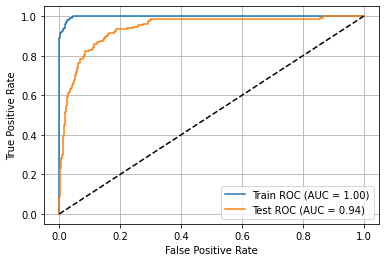

Test Confusion Matrix:
[[1379   92]
 [  36  116]]


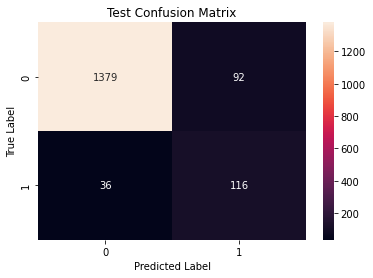

Train Confusion Matrix:
[[3352   81]
 [  50 1666]]


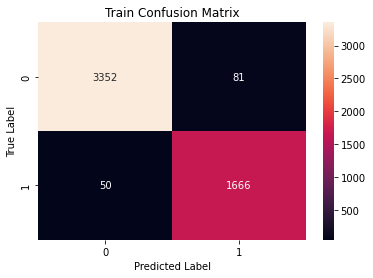

Test Precision: 0.56
Test Recall: 0.76
Test Confusion Matrix:
[[1379   92]
 [  36  116]]

Train Precision: 0.95
Train Recall: 0.97
Train Confusion Matrix:
[[3352   81]
 [  50 1666]]


In [49]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGISTIC REGRESSION ,RANDOM FOREST, XG-BOOST AND DECISION TREE AS BASE LEARNERS**

In [50]:
# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7843518716832061
ROC AUC score of ensemble model: 0.8217221546388065


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

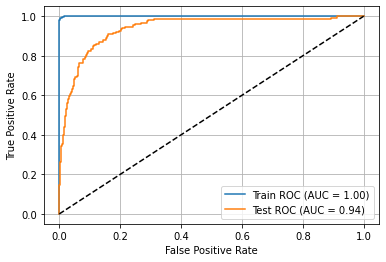

Test Confusion Matrix:
[[1382   89]
 [  45  107]]


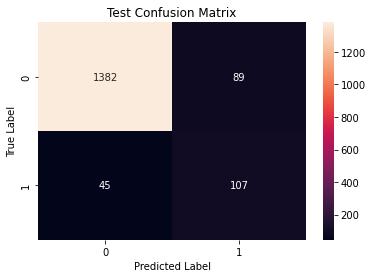

Train Confusion Matrix:
[[3409   24]
 [  11 1705]]


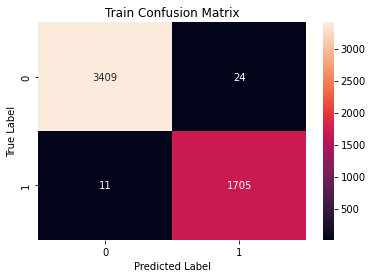

Test Precision: 0.55
Test Recall: 0.70
Test Confusion Matrix:
[[1382   89]
 [  45  107]]

Train Precision: 0.99
Train Recall: 0.99
Train Confusion Matrix:
[[3409   24]
 [  11 1705]]


In [51]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENTATION OF ENSEMBLE MODEL USING LOGESTIC REGRESSION , RANDOM FOREST , XG-BOOST, DECISION TREE, SVM WITH RBF KERNAL**

In [52]:
# Define the base learners
lr = LogisticRegression(C=100, penalty='l2', max_iter=10000, random_state=42)
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=10, min_samples_split=500, random_state=42)

svm_rbf = SVC(C=10, kernel='rbf',probability=True)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb), ('dt', dt), ('svm_rbf', svm_rbf)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.791806734826371
ROC AUC score of ensemble model: 0.8345401445489998


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

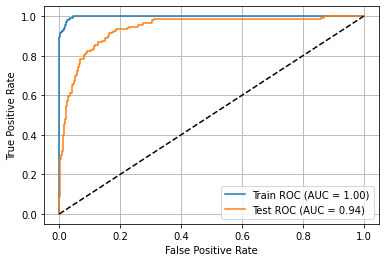

Test Confusion Matrix:
[[1381   90]
 [  41  111]]


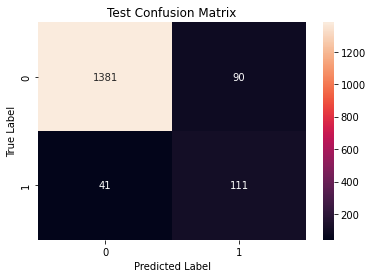

Train Confusion Matrix:
[[3352   81]
 [  47 1669]]


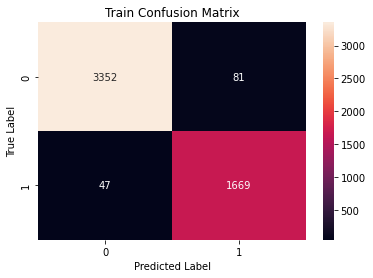

Test Precision: 0.55
Test Recall: 0.73
Test Confusion Matrix:
[[1381   90]
 [  41  111]]

Train Precision: 0.95
Train Recall: 0.97
Train Confusion Matrix:
[[3352   81]
 [  47 1669]]


In [53]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **NOW IMPLEMENTATION OF ENSEMBLE MODEL WITH RANDOM FOREST AND XGBOOST AS BASE LEARNERS**

In [54]:
# Define the base learners
rf = RandomForestClassifier(n_estimators=52, max_depth=20, min_samples_split=4, 
                            min_samples_leaf=1, max_features='auto', bootstrap=False, random_state=42)
xgb = XGBClassifier(n_estimators=52, max_depth=33, learning_rate=0.6432882184423532, gamma=0.3881699262065219, 
                    min_child_weight=3, subsample=0.9414648087765252, colsample_bytree=0.575474177875879, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[ ('rf', rf), ('xgb', xgb)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7721194971270575
ROC AUC score of ensemble model: 0.7817878099395327


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

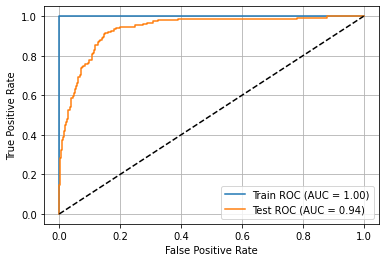

Test Confusion Matrix:
[[1400   71]
 [  59   93]]


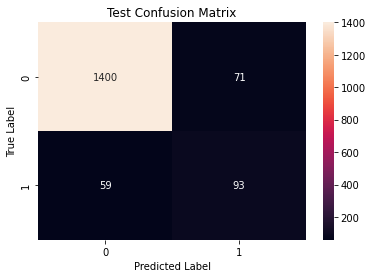

Train Confusion Matrix:
[[3433    0]
 [   1 1715]]


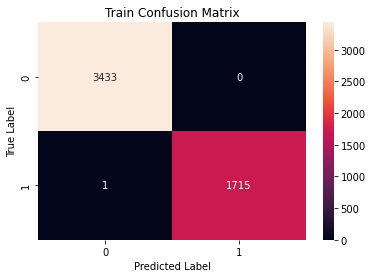

Test Precision: 0.57
Test Recall: 0.61
Test Confusion Matrix:
[[1400   71]
 [  59   93]]

Train Precision: 1.00
Train Recall: 1.00
Train Confusion Matrix:
[[3433    0]
 [   1 1715]]


In [55]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

# **IMPLEMENATION OF ENSEMBLE MODEL WITH 3 RANDOM FOREST MODEL WITH DIFFERENT PARAMETERS AS BASE LEARNERS**

In [56]:
# Define the base learners
rf1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2 = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf3 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')

# Fit the voting classifier on the training data
voting_clf.fit(x_train_res, y_train_res)

# Predict on the testing data
y_pred = voting_clf.predict(x_te)

# Evaluate the f1 score and ROC AUC score of the ensemble model
f1 = f1_score(y_te, y_pred, average='macro')
roc_auc = roc_auc_score(y_te, y_pred, multi_class='ovr')
print("F1 score of ensemble model:", f1)
print("ROC AUC score of ensemble model:", roc_auc)

F1 score of ensemble model: 0.7885523006186018
ROC AUC score of ensemble model: 0.8413494221617948


# **PLOTTING AUC-ROC CURVE AND CONFUSION MATRIX FOR THE ABOVE ENSEMBLE MODEL VOTING CLASSIFIER**

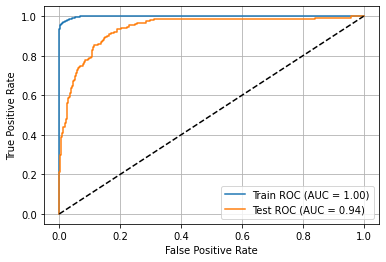

Test Confusion Matrix:
[[1372   99]
 [  38  114]]


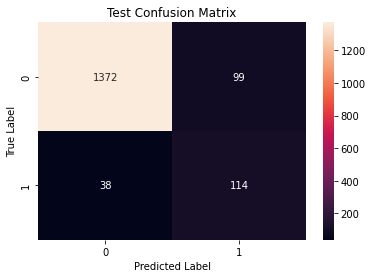

Train Confusion Matrix:
[[3345   88]
 [  35 1681]]


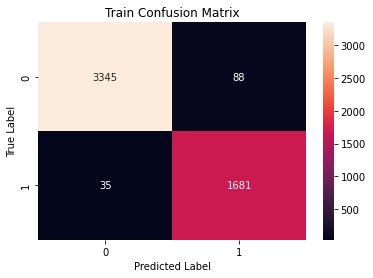

Test Precision: 0.54
Test Recall: 0.75
Test Confusion Matrix:
[[1372   99]
 [  38  114]]

Train Precision: 0.95
Train Recall: 0.98
Train Confusion Matrix:
[[3345   88]
 [  35 1681]]


In [57]:
# Compute the probabilities of class 1 for the test set
y_test_pred_proba = voting_clf.predict_proba(x_te)[:,1]

# Compute the probabilities of class 1 for the training set
y_train_pred_proba = voting_clf.predict_proba(x_train_res)[:,1]

# Compute the ROC AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_te, y_test_pred_proba)
auc_test = roc_auc_score(y_te, y_test_pred_proba)

# Compute the ROC AUC for the training set
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
auc_train = roc_auc_score(y_train_res, y_train_pred_proba)

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Predict the labels of the test set
y_test_pred = voting_clf.predict(x_te)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_te, y_test_pred)

# Print the confusion matrix for the test set
print("Test Confusion Matrix:")
print(cm_test)

# Plot the confusion matrix for the test set
sns.heatmap(cm_test, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')
plt.show()

# Predict the labels of the training set
y_train_pred = voting_clf.predict(x_train_res)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train_res, y_train_pred)

# Print the confusion matrix for the training set
print("Train Confusion Matrix:")
print(cm_train)

# Plot the confusion matrix for the training set
sns.heatmap(cm_train, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Train Confusion Matrix')
plt.show()

# Compute precision and recall for the test set
precision = precision_score(y_te, y_test_pred)
recall = recall_score(y_te, y_test_pred)

# Print precision, recall, and confusion matrix for the test set
print("Test Precision: {:.2f}".format(precision))
print("Test Recall: {:.2f}".format(recall))
print("Test Confusion Matrix:")
print(cm_test)

# Compute precision and recall for the training set
precision = precision_score(y_train_res, y_train_pred)
recall = recall_score(y_train_res, y_train_pred)

# Print precision, recall, and confusion matrix for the training set
print("\nTrain Precision: {:.2f}".format(precision))
print("Train Recall: {:.2f}".format(recall))
print("Train Confusion Matrix:")
print(cm_train)

In [77]:
from prettytable import PrettyTable

print("THIS IS different ensemble  MODEL PERFORMANCE IN 50:50 COMBINATIONS")

table = PrettyTable()
table.field_names = ["MODEL COMBINATION", "OVERSAMPLING RATIO", "AUC SCORE", "F1 SCORE", "TRAIN AUC", "TEST AUC", "TRAIN PRECISION", "TRAIN RECALL", "TEST PRECISION", "TEST RECALL"]
table.add_row(["LR+SVM+DT+RANDOM FOREST+XGBOOST", "50:50", 0.84, 0.80, 1.00, 0.94, 0.95, 0.97, 0.56, 0.76])
table.add_row([ "LR+DT+RANDOM FOREST+XGBOOST", "50:50", 0.82, 0.78, 1.00, 0.94, 0.99, 0.99, 0.55, 0.70])
table.add_row([ "LR+svm_rbf+DT+RANDOM FOREST+XGBOOST", "50:50", 0.83, 0.79, 1.00, 0.94, 0.95, 0.97, 0.55, 0.73])
table.add_row([ "RANDOM FOREST+XGBOOST", "50:50", 0.78, 0.77, 1.00, 0.93, 1.00, 1.00, 0.57, 0.61])
table.add_row([ "RANDOM FOREST+RANDOM FOREST+RANDOM FOREST", "50:50", 0.84, 0.78, 1.00, 0.94, 0.95, 0.98, 0.54, 0.75])
print(table)

THIS IS different ensemble  MODEL PERFORMANCE IN 50:50 COMBINATIONS
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|             MODEL COMBINATION             | OVERSAMPLING RATIO | AUC SCORE | F1 SCORE | TRAIN AUC | TEST AUC | TRAIN PRECISION | TRAIN RECALL | TEST PRECISION | TEST RECALL |
+-------------------------------------------+--------------------+-----------+----------+-----------+----------+-----------------+--------------+----------------+-------------+
|      LR+SVM+DT+RANDOM FOREST+XGBOOST      |       50:50        |    0.84   |   0.8    |    1.0    |   0.94   |       0.95      |     0.97     |      0.56      |     0.76    |
|        LR+DT+RANDOM FOREST+XGBOOST        |       50:50        |    0.82   |   0.78   |    1.0    |   0.94   |       0.99      |     0.99     |      0.55      |     0.7     |
|    LR+svm_rbf+DT+RANDOM FOREST+XGBOOST    |  

# **OVERALL CONCLUSION**

##**1. PERFORMENCE GETTING INCREASED WHEN WE USED ENSEMBLE MODEL WITH DIFFERENT BASE LEARNERS COMBINATION THAN INDIVISUAL MODEL THAT WE HAVE DONE EARLIER**

##**2. F1 SCORE IS GETTING BETWEEN 75 TO 80 IN ALL THE COMBINATIONS , I THINK WHICH IS VERY GOOD SINCE THIS IS HIGHLY IMBALANCED PROBLEM**

##**3. I HAVE ALSO TRIED FEATURE SELECTION TECHNIQUE BUT THAT NOT WORKED WELL AT ALL SO TRIED ENSEMBLES MODEL WITH DIFFERENT BASE LEARNERS COMBINATION**

##**4. AUC SCORE WE ARE GETTING BETWEEN 80-85 WHICH IS GOOD I THINK IN THIS SCENARIO**

##**5. OUR MODEL PERFORMING REALLY WELL ON TRAIN DATA SLIGHTLY LESS ON TEST DATA BUT I THINK THIS IS GOOD , YES WE CAN IMPROVE FURTHER USING SOME MORE HACKS**

##**6. I THINK WE DOING GOOD WITH THE PERFORMENCE BECAUSE THIS IS HIGHLY IMBALANCED DATASET ALMOST 91:10 NON FRAUD-FRAUD RESPECTIVELY STILL WE ARE GETTING GOOD PRECISION AND RECALL BUT I THINK WE CAN STILL IMPROVE IT FURTHER USING NEURAL NETWORK TECHNIQUES**
